<img src="../../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Visual Change Detection Behavior + Optical Physiology </h1> 
<h2 align="center">Summer Workshop on the Dynamic Brain </h2> 
<h3 align="center">Tuesday, August 21, 2018</h3> 

<img src="../../resources/change_detection_schematic.png" height="400" width="400">  


This notebook will introduce you to the Visual Behavior pilot dataset. This pre-release dataset uses 2-photon calcium imaging (also called optical physiology or ophys) to measure neural activity in behaving mice, and was collected during piloting for the new Visual Behavior Brain Observatory. Production data collection for the Observatory will begin September 2018 and data will be publicly released in 2019. The insights obtained here at SWDB may help shape the collection of the production dataset. 

The change detection task consists of a series of image presentations. Each image flash is 250ms followed by 500ms of gray screen. The task for the mouse is to lick in a 750ms response window following a change in image identity. On each trial, a change time is scheduled. On go trials, a change in image identity occurs. On catch trials, no image change occurs (aka 'sham change'), and we measure false alarm rates in the same 750ms response window. Correct responses are rewarded and licks outside the response window result in a timeout.

There are 8 natural scene images shown in each behavioral session, with 4 unique sets of 8 that can shown in different sessions. One of these image sets has been seen by the mouse many times during initial behavioral training, while the other 3 image sets are seen for the first time under the microscope. 

In this notebook, we will describe the dimensions of the dataset, the core components of each experimental session, and the tools for accessing and analyzing the data. 

You will be working with a single experimental session recorded in a specific cre line and visual area. Other students will have sessions with different areas, cre lines and stimulus sets. As you work through the exercises, compare results with your neighbors to see what the similarities and differences are.

At the end of the notebook, you will compute a value for a metric called lifetime sparseness that measures each neuron's selectivity for stimulus identity, and take the mean across the population of neurons in your experiment session. We will collect the mean sparseness value from each student's unique experiment session to collectively make a plot that compares how sparseness varies across excitatory and inhibitory cell populations, and for stimulus sets that are novel or familiar to the mouse. 

** Outline:**
1.	Explore the dataset using the manifest file
2.	VisualBehaviorOphysDataset class – accessing data and metadata
3.	Optical physiology data – calcium traces and rois
4.	Change detection behavior data – running speed, licks, rewards, and visual stimuli
5.	Trials dataframe – structure for organizing behavior data by trials
6.	ResponseAnalysis class – structures for analyzing cell responses by trials and stimulus flashes
7.	Lifetime sparseness – computing a selectivity metric for responsive cells
8.	Project ideas


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p>Let's get started

</div>

In [1]:
# you will need these libraries for computation & data manipulation
import os
import numpy as np
import pandas as pd

# matplotlib is a standard python visualization package
import matplotlib.pyplot as plt
%matplotlib inline

# seaborn is another library for statistical data visualization
# seaborn style & context settings make plots pretty & legible
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})
sns.set_style('white')
sns.set_palette('deep');

# this makes print statements complaint with python 3 formatting
from __future__ import print_function

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>The dimensions of the dataset are described in the manifest file. You can inspect the manifest to identify experiments of interest and their metadata. 

<p>The manifest file is located in the cache directory, along with the data itself. 

<p>Make sure your `drive_path` is set properly, and complete the following task to load and inspect the `manifest_file`. </div>



In [2]:
#make sure your drive path is correct! 
# macOS/OS X
# drive_path = '/Volumes/Brain2018/visual_behavior/'

# Windows (a good guess)
# drive_path = 'e:/visual_behavior'

# Linux (will vary; the following is possibly what Ubuntu will do)
# drive_path = '/media/Brain2018/visual_behavior'

# AWS
drive_path = '/data/dynamic-brain-workshop/visual_behavior'

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 1.1:**  Get information about what's in the dataset 

<p>Read in 'visual_behavior_data_manifest.csv' using pandas and explore the columns to see the available visual areas, cre lines, and session types. 

</div>

In [3]:
manifest_file = 'visual_behavior_data_manifest.csv'

In [4]:
manifest = pd.read_csv(os.path.join(drive_path,manifest_file))

In [5]:
manifest.head()

,experiment_id,experiment_container_id,targeted_structure,imaging_depth,cre_line,reporter_line,full_genotype,session_type,donor_id,specimen_id,experiment_date
0,644942849,644919226,VISp,175,Vip-IRES-Cre,Ai148,Vip-IRES-Cre;Ai148,behavior_session_A,329071,596175193,10/24/2017 10:32
1,645035903,644919226,VISp,175,Vip-IRES-Cre,Ai148,Vip-IRES-Cre;Ai148,behavior_session_B,329071,596175193,10/25/2017 10:34
2,645086795,644919226,VISp,175,Vip-IRES-Cre,Ai148,Vip-IRES-Cre;Ai148,behavior_session_C,329071,596175193,10/26/2017 10:27
3,645362806,644919226,VISp,175,Vip-IRES-Cre,Ai148,Vip-IRES-Cre;Ai148,behavior_session_D,329071,596175193,10/30/2017 11:41
4,646922970,646555436,VISp,175,Vip-IRES-Cre,Ai148,Vip-IRES-Cre;Ai148,behavior_session_A,330982,596393048,11/7/2017 14:19


In [6]:
print('targeted structures:', manifest.targeted_structure.unique())
print('cre_lines:', manifest.cre_line.unique())
print('stimulus_types:', manifest.session_type.unique())

targeted structures: ['VISp' 'VISal']
cre_lines: ['Vip-IRES-Cre' 'Slc17a7-IRES2-Cre']
stimulus_types: ['behavior_session_A' 'behavior_session_B' 'behavior_session_C'
 'behavior_session_D']


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 1.2:**  Everyone gets an experiment! 

<p>Get your experiment ID and assign it to a variable called `experiment_id`

<p>What is the `targeted_structure`, `cre_line` and `session_type` for your `experiment_id`? 

</div>

In [7]:
experiment_id = 715887471

In [8]:
manifest[manifest.experiment_id==experiment_id]

,experiment_id,experiment_container_id,targeted_structure,imaging_depth,cre_line,reporter_line,full_genotype,session_type,donor_id,specimen_id,experiment_date
49,715887471,715094648,VISal,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_B,384942,687987489,6/28/2018 15:34


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 1.3:**  What is in an experiment container? 

<p>The experiment container describes a set of experiment sessions performed at the same location (targeted area and imaging depth) in the same mouse that targets the same set of cells. All the sessions in an experiment container have a common `experiment_container_id`.

<p>Get a the `experiment_container_id` for your `experiment_id` and find out what other sessions were recorded at that same location.

<p>Do all experiment containers have the same number of sessions associated with them? 
</div>

In [9]:
experiment_container_id = manifest[manifest.experiment_id==experiment_id].experiment_container_id.values[0]
print(experiment_container_id)

715094648


In [10]:
manifest[manifest.experiment_container_id==experiment_container_id]

,experiment_id,experiment_container_id,targeted_structure,imaging_depth,cre_line,reporter_line,full_genotype,session_type,donor_id,specimen_id,experiment_date
48,715228642,715094648,VISal,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,384942,687987489,6/27/2018 13:08
49,715887471,715094648,VISal,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_B,384942,687987489,6/28/2018 15:34
50,716337289,715094648,VISal,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_C,384942,687987489,6/29/2018 14:27
51,716602547,715094648,VISal,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_D,384942,687987489,7/2/2018 14:58


In [11]:
manifest.groupby('experiment_container_id').size()

experiment_container_id
639001089    4
644919226    4
646555436    4
648562391    3
652784528    3
661409179    4
670266085    4
682951696    2
692315205    4
695444116    4
700821114    4
712038821    4
715027436    4
715094648    4
719538773    4
719860866    4
dtype: int64

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>The VisualBehaviorOphysDataset object</h2>
<p>The dataset object contains all the data and metadata for a single experiment session, including dF/F traces, behavior data, and timing information. 

<p>Provide your `experiment_id` and your `cache_dir` (which here is the `drive_path` variable) to load the data for an experiment. 

<p>Use help to see what functions are contained in the `VisualBehaviorOphysDataset` class. 

<p>**Note: experiment data is loaded upon initialization of the class. Data can be accessed directly as an attribute of the class (ex: rewards = dataset.rewards) or by using 'get' functions (ex: rewards = dataset.get_rewards()). 

</div>

In [12]:
# import visual behavior dataset class from the visual_behavior package
from visual_behavior.ophys.dataset.visual_behavior_ophys_dataset import VisualBehaviorOphysDataset

/Users/michaelbu/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [13]:
dataset= VisualBehaviorOphysDataset(experiment_id, cache_dir=drive_path)

In [14]:
help(VisualBehaviorOphysDataset)

Help on class VisualBehaviorOphysDataset in module visual_behavior.ophys.dataset.visual_behavior_ophys_dataset:

class VisualBehaviorOphysDataset(__builtin__.object)
 |  Methods defined here:
 |  
 |  __init__(self, experiment_id, cache_dir=None)
 |      Initialize visual behavior ophys experiment dataset.
 |          Loads experiment data from cache_dir, including dF/F traces, roi masks, stimulus metadata, running speed, licks, rewards, and metadata.
 |      
 |          All available experiment data is read upon initialization of the object.
 |          Data can be accessed directly as attributes of the class (ex: dff_traces = dataset.dff_traces) or by using functions (ex: dff_traces = dataset.get_dff_traces()
 |      
 |      Parameters
 |      ----------
 |      experiment_id : ophys experiment ID
 |      cache_dir : directory where data files are located
 |  
 |  get_analysis_dir(self)
 |  
 |  get_cache_dir(self)
 |  
 |  get_cell_index_for_cell_specimen_id(self, cell_specimen_id

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 2.1:**  What is an experiment dataset? 

<p>Use tab completion to see what is in the dataset object for an experiment session

<p>What is in the `metadata` attribute? Make sure it matches what you found in the manifest for this `experiment_id`.

</div>


In [15]:
dataset.metadata

,ophys_experiment_id,experiment_container_id,targeted_structure,imaging_depth,cre_line,reporter_line,full_genotype,session_type,donor_id,experiment_date,specimen_id,ophys_frame_rate,stimulus_frame_rate
715887471,715887471,715094648,VISal,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_B,384942,2018-06-28,687987489,31.0,60.0


In [16]:
# make sure this is the experiment you selected
print('targeted_structure:', dataset.metadata.targeted_structure.values[0])
print('cre line:', dataset.metadata.cre_line.values[0])
print('imaging_depth:', dataset.metadata.imaging_depth.values[0])

targeted_structure: VISal
cre line: Slc17a7-IRES2-Cre
imaging_depth: 175


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Optical physiology data - max projection, fluorescence traces and roi masks</h2>

<p>Let's use the dataset class to access neuron fluorescence timeseries, roi masks, and metadata

</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 2.2:** Get the maximum intensity projection image using the `max_projection` attribute for your dataset and display it. 
</div>

(-0.5, 446.5, 511.5, -0.5)

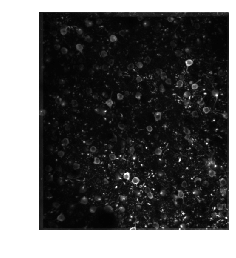

In [17]:
plt.imshow(dataset.max_projection,cmap='gray',)
plt.axis('off')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 2.3: Get dF/F traces and ophys timestamps**

<p>Get the fluorescence traces and ophys timestamps. What are the dimensions?

<p>`dff_traces` is an array where rows correspond to different cells that were imaged and columns correspond to frames of the 2P movie. `timestamps_ophys` is an array of timestamps for each 2P imaging frame. 

<p>**Note that there are two ways to access this information - by using functions, or directly as attributes of the dataset object. These two methods are shown below. 

</div>

In [18]:
# function method of accessing data
timestamps_ophys, dff_traces = dataset.get_dff_traces()

In [19]:
print('shape of dff_traces:',dff_traces.shape)
print('shape of timestamps_ophys:',timestamps_ophys.shape)

shape of dff_traces: (229, 111696)
shape of timestamps_ophys: (111696,)


In [20]:
# attribute method of accesing data
dff_traces = dataset.dff_traces
timestamps_ophys = dataset.timestamps_ophys

In [21]:
# you can also skip the step of assigning the attribute to a variable and use the datasest attribute directly
print('shape of dff_traces:',dataset.dff_traces.shape)
print('shape of timestamps_ophys:',dataset.timestamps_ophys.shape)

shape of dff_traces: (229, 111696)
shape of timestamps_ophys: (111696,)


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 2.4: Plot the dF/F trace for a cell**

<p>Plot the dF/F trace for one cell by indexing into the `dff_traces` array. Use `timestamps_ophys` to plot the y_axis in seconds. 

<p>Try plotting the trace for a different cell.

</div>

In [22]:
# pick a cell 
cell_index = 8

Text(0,0.5,'dF/F')

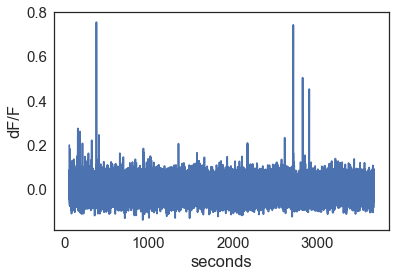

In [23]:
plt.plot(dataset.timestamps_ophys,dataset.dff_traces[cell_index])
plt.xlabel('seconds')
plt.ylabel('dF/F')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 2.5: Going between `cell_index` and `cell_specimen_id`** 
<p>Get the `cell_specimen_id` for your `cell_index` using a function provided in the dataset class. 

<p>Is there a function to translate in the opposite direction?
</div>

In [24]:
cell_specimen_id = dataset.get_cell_specimen_id_for_cell_index(cell_index)
print(cell_specimen_id)

715928902


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 2.6: Accessing roi masks two ways** 

<p>1) Plot the roi mask for that cell using `cell_specimen_id` and `roi_mask_dict`. 

<p>Hint: `cell_specimen_id` needs to be passed into `roi_mask_dict` as a string. 

<p>2) Alternatively, plot the roi mask for that cell using `roi_mask_array` and `cell_index`.
</div>

/Users/michaelbu/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


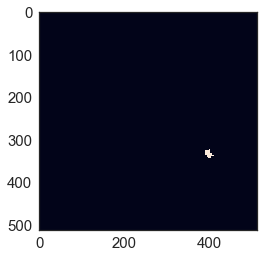

In [25]:
# use cell_specimen_id for roi_mask_dict
plt.imshow(dataset.roi_mask_dict[str(cell_specimen_id)])
plt.grid('off')

/Users/michaelbu/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


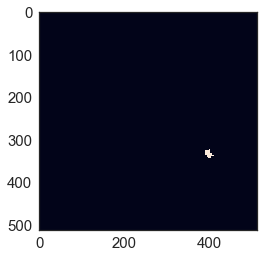

In [26]:
# use cell_index for roi_mask_array
plt.imshow(dataset.roi_mask_array[cell_index])
plt.grid('off')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Behavior timeseries and events - running, licks, rewards, and visual stimuli </h2>
<p>As the mouse performs the behavioral task, it is free to run on a disk. The task is a go/no-go style task with licking as the behavioral response. When a mouse correctly licks the water spout, a reward is delivered. 

<p>Running, licks and rewards are measured at the stimulus frame display rate and share timestamps with the stimulus. </div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 3.1: Get running speed trace and timestamps** 

<p>Get the `running_speed` attribute of the dataset object. 

<p>Note that running speed is stored in a dataframe. What are the other columns of this dataframe? 

<p>Runnning speed shares timestamps with the visual stimulus. Compare the values of running timestamps from the `running_speed` dataframe with the values in the dataset attribute `timestamps_stimulus`. 
</div>

In [27]:
dataset.running_speed.head()

,frame,running_speed,time
0,0,5.810851,68.98893
1,1,5.933383,69.00560
2,2,6.065008,69.02230
3,3,7.099349,69.03895
4,4,8.990454,69.05565


In [28]:
print('running speed timestamps:',dataset.running_speed.time.values)

running speed timestamps: [  68.98893   69.0056    69.0223  ... 3668.84796 3668.86462 3668.88133]


In [29]:
print('stimulus timestamps:',dataset.timestamps_stimulus)

stimulus timestamps: [  68.98893   69.0056    69.0223  ... 3668.84796 3668.86462 3668.88133]


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 3.2: Plot running speed**

<p>1) Plot the values for running speed from the `running_speed` column of the dataframe. 

<p>2) Plot the x-axis in seconds, using `timestamps_stimulus` or using the `time` column of the `running_speed` dataframe. 

<p>Running speed is measured in cm/s. Label the axes appropriately.
</div>

Text(0,0.5,'running speed (cm/s)')

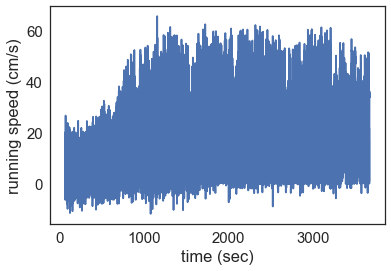

In [30]:
plt.plot(dataset.timestamps_stimulus,dataset.running_speed.running_speed.values)
plt.xlabel('time (sec)')
plt.ylabel('running speed (cm/s)')

Text(0,0.5,'running speed (cm/s)')

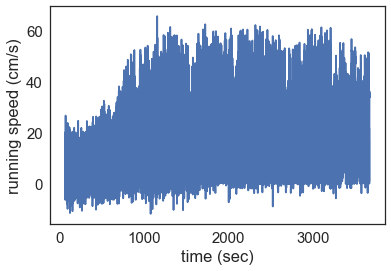

In [31]:
plt.plot(dataset.running_speed.time.values,dataset.running_speed.running_speed.values)
plt.xlabel('time (sec)')
plt.ylabel('running speed (cm/s)')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 3.3: Plot licking, reward times, and running trace on the same figure**
    
<p>1) Plot `running_speed` as above, but set xlims to focus on a 1 minute portion of the behavior session, from x=600 to x=660. 

<p>2) Plot `rewards` as points (not a line), at y = -10. Set marker='o' and linestyle='None'. Note that `rewards` is a dataframe. Use the values of the `time` column to get x-axis values to plot.

<p>Hint: You will need to create an array of len(dataset.rewards.time.values) filled with -10 to use as y-axis values to plot. np.repeat() is a convenient function for this.

<p>3) Plot `licking` times using plt.vlines() with ymin=-10 and ymax=-5. 

<p>4) Create a legend. Bonus: place the legend outside of the main figure.

<p>What is the relationship between running, licking and rewards? 
</div>

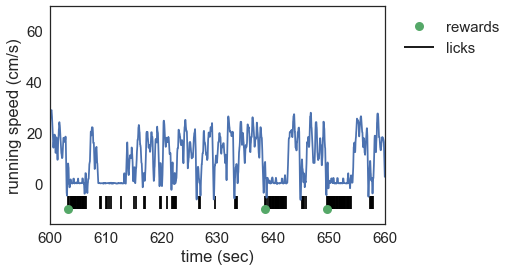

In [32]:
# plot running
plt.plot(dataset.timestamps_stimulus,dataset.running_speed.running_speed.values)
plt.xlim(600,660)
# plot rewards
reward_y_vals = np.repeat(-10,repeats=len(dataset.rewards.time.values))
plt.plot(dataset.rewards.time.values,reward_y_vals,marker='o',linestyle='None',label='rewards',)
# plot licks
lick_y_vals = np.repeat(-10,repeats=len(dataset.licks.time.values))
plt.vlines(dataset.licks.values, -10, -5, label='licks')

plt.xlabel('time (sec)')
plt.ylabel('running speed (cm/s)')
plt.legend(loc=9, bbox_to_anchor=(1.2,1))

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 3.4: Get the stimulus table**

<p>Get the `stimulus_table` attribute from the `dataset` object to identify the times of stimulus presentations. How many stimulus flashes were there? 
</div>

In [33]:
dataset.stimulus_table.head()

,flash_number,start_time,end_time,image_name
0,0,69.00560,69.25562,im047
1,1,69.75609,70.00626,im047
2,2,70.50666,70.75684,im047
3,3,71.25722,71.50744,im047
4,4,72.00789,72.25806,im047


In [34]:
print('number of stimulus presentations =',len(dataset.stimulus_table))

number of stimulus presentations = 4585


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 3.5: Plot visual stimulus presentations with behavior events**

<p>1) Copy and paste your code from Exercise 3.3, but now set xlims to zoom in on a 20 second window from t=600 to t=620. 

<p>2) Plot stimulus presentations using the `start_time` and `end_time` columns of the `stimulus_table` with plt.axvspan(). Set alpha=0.3 & facecolor='gray'.

<p>Hint: Loop through each row of the stimulus table to plot all stimulus flashes

</div>

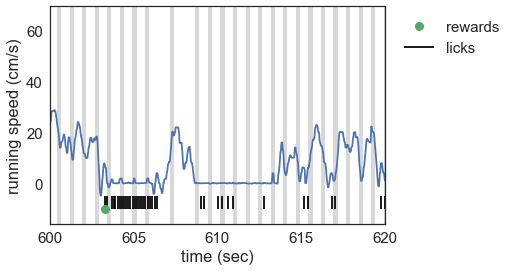

In [35]:
# plot running
plt.plot(dataset.timestamps_stimulus,dataset.running_speed.running_speed.values)
plt.xlim(600,660)
# plot rewards
reward_y_vals = np.repeat(-10,repeats=len(dataset.rewards.time.values))
plt.plot(dataset.rewards.time.values,reward_y_vals,marker='o',linestyle='None',label='rewards',)
# plot licks
lick_y_vals = np.repeat(-10,repeats=len(dataset.licks.time.values))
plt.vlines(dataset.licks.values, -10, -5, label='licks')

for index in dataset.stimulus_table.index:
    row_data = dataset.stimulus_table.iloc[index]
    plt.axvspan(xmin=row_data.start_time,xmax=row_data.end_time,facecolor='gray',alpha=0.3)

plt.xlim(600,620)
plt.xlabel('time (sec)')
plt.ylabel('running speed (cm/s)')
plt.legend(loc=9, bbox_to_anchor=(1.2,1))


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 3.6: Get visual stimulus template and metadata**

<p>Get `stimulus_metadata` and `stimulus_template` from the dataset object. How do they relate to each other? 

<p>The first dimension of `stimulus_template` corresponds to the `image_index` in `stimulus_metadata`.
</div>

In [36]:
stimulus_metadata = dataset.stimulus_metadata
stimulus_metadata

,image_index,image_name
0,0,im012
1,1,im013
2,2,im115
3,3,im047
4,4,im044
5,5,im057
6,6,im036
7,7,im078


In [37]:
stimulus_template = dataset.stimulus_template
stimulus_template.shape

(8, 918, 1174)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 3.7: Plot a visual stimulus**

<p>1) Plot an image from the `stimulus_template` using plt.imshow. 

<p>2) Show the `image_name` in the title.

<p>Hint: Use `image_index` to translate between `stimulus_template` and `stimulus_metadata`.

</div>

Text(0.5,1,'im115')

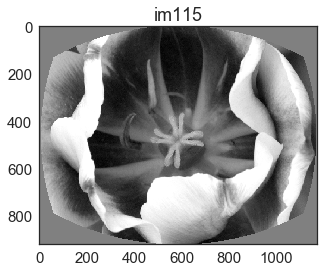

In [38]:
image_index = 2
plt.imshow(stimulus_template[image_index],cmap='gray')

image_name = stimulus_metadata[stimulus_metadata.image_index==image_index].image_name.values[0]
plt.title(image_name)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Behavior trials DataFrame</h2>
<p>The `trials` dataframe organizes behavior events (including licking and rewards), stimulus information (what stimulus was shown before and after the scheduled change time) and metadata (such as whether the trial was a 'go' trial or a 'catch' trial) for each behavioral trial. 

<p>This structure is convenient for data exploration and analysis.
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 4.1: Explore the trial records**

<p>1) Get the `trials` attribute of the `dataset` object. What are the columns of this dataframe? What are the rows?

<p>How many trials were there? 

<p>How many of those trials had stimulus changes, aka 'go' trials? How many 'catch' trials?

<p>What images were shown in this behavior session? 
</div>

In [39]:
trials = dataset.trials
trials.head()

,trial,change_time,initial_image_name,change_image_name,trial_type,trial_type_color,response,response_type,response_window,lick_times,response_latency,rewarded,reward_times,reward_volume,reward_rate,start_time,end_time,trial_length,mouse_id,start_date_time
0,0,147.81971,im047,im047,catch,yellow,0.0,CR,"[0.15, 0.75]",[150.15495],2.33524,False,[],0.000,2.694428,144.80055,150.80546,6.005129,M384942,2018-06-28 15:57:29.511000-07:00
1,1,165.83445,im115,im013,go,lightgreen,0.0,MISS,"[0.15, 0.75]",[],NaN,True,[],0.000,2.869450,162.81529,171.07207,8.256960,M384942,2018-06-28 15:57:29.511000-07:00
2,2,174.09123,im013,im013,catch,yellow,0.0,CR,"[0.15, 0.75]",[177.69413],3.60290,False,[],0.000,2.869450,171.07207,177.82756,6.755717,M384942,2018-06-28 15:57:29.511000-07:00
3,3,189.10344,im057,im057,catch,yellow,0.0,CR,"[0.15, 0.75]",[195.07499],5.97155,False,[],0.000,2.929545,186.83496,195.09168,8.257009,M384942,2018-06-28 15:57:29.511000-07:00
4,4,205.61699,im057,im036,go,darkgreen,1.0,HIT,"[0.15, 0.75]","[206.26751, 206.55105, 206.93466, 207.03475]",0.65052,True,[206.26751],0.007,3.165730,201.09659,207.10149,6.005128,M384942,2018-06-28 15:57:29.511000-07:00


In [40]:
trials.keys()

Index([u'trial', u'change_time', u'initial_image_name', u'change_image_name',
       u'trial_type', u'trial_type_color', u'response', u'response_type',
       u'response_window', u'lick_times', u'response_latency', u'rewarded',
       u'reward_times', u'reward_volume', u'reward_rate', u'start_time',
       u'end_time', u'trial_length', u'mouse_id', u'start_date_time'],
      dtype='object')

In [41]:
print('number of trials =',len(trials))

number of trials = 231


In [42]:
print('number of go trials =',len(trials[trials.trial_type=='go']))

number of go trials = 200


In [43]:
print('number of catch trials =',len(trials[trials.trial_type=='catch']))

number of catch trials = 31


In [44]:
images = trials.change_image_name.unique()
print(images)

['im047' 'im013' 'im057' 'im036' 'im012' 'im115' 'im044' 'im078']


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 4.2: Get the behavioral response probability for go and catch trials**

<p>Response probability is the fraction of trials where the mouse emitted a lick during the response window. 

<p>The value of the `response` column is a boolean indicating whether or not the mouse emitted a lick on that trial.

<p>1) Select all the 'go' trials by filtering the dataframe by `trial_type`.

<p>2) Take the mean of the `response` column values for the selected trials to quantify the fraction of 'go' trials where the mouse emitted a behavioral response. 

<p>3) Repeat for 'catch' trials.

<p>***Add your values for response probability on go and catch trials to the plot on the board and draw a line between them***
</div>

In [45]:
print('response probability go trials:',trials[trials.trial_type=='go'].response.mean())

response probability go trials: 0.77


In [46]:
print('response probability catch trials:',trials[trials.trial_type=='catch'].response.mean())

response probability catch trials: 0.225806451613


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Bonus exercise 4.3: Plot response probability across images for go trials**

<p>1) Loop through the image names in `trials.change_image_name.unique()`

<p>2) Filter the `trials` dataframe by `change_image_name` and `trial_type` to get 'go' trials for each image.

<p>3) Quantify the fraction of 'go' trials with a `response` for each image. 

<p>3) Plot the mean response probability for each image. 
</div>

(0, 1)

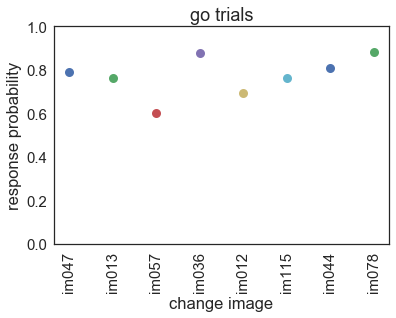

In [47]:
trial_type = 'go'
for i,image in enumerate(images): 
    selected_trials = trials[(trials.change_image_name==image)&(trials.trial_type==trial_type)]
    response_probability = selected_trials.response.mean()
    plt.plot(i,response_probability,'o')
plt.xticks(np.arange(0,len(images),1),images,rotation=90)
plt.ylabel('response probability')
plt.xlabel('change image')
plt.title('go trials')
plt.ylim(0,1)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 4.4: Plot a lick raster**

<p>Provide the `trials` dataframe to the function below to plot a lick raster.

<p>Is the mouse performing the task consistently across the whole session?
</div>

In [48]:
def make_lick_raster(trials):
    fig,ax = plt.subplots(figsize=(5,10))
    for trial in trials.trial.values: 
        trial_data = trials.iloc[trial]
        # get times relative to change time
        trial_start = trial_data.start_time - trial_data.change_time
        lick_times = [(t - trial_data.change_time) for t in trial_data.lick_times]
        reward_time = [(t - trial_data.change_time) for t in trial_data.reward_times]
        # plot trials as colored rows
        ax.axhspan(trial, trial + 1, -200, 200, color=trial_data.trial_type_color, alpha=.5)
        # plot reward times
        if len(reward_time) > 0:
            ax.plot(reward_time[0], trial + 0.5, '.', color='b', label='reward', markersize=6)
        ax.vlines(trial_start, trial, trial + 1, color='black', linewidth=1)
        # plot lick times
        ax.vlines(lick_times, trial, trial + 1, color='k', linewidth=1)
        # annotate change time
        ax.vlines(0, trial, trial + 1, color=[.5, .5, .5], linewidth=1)
    # gray bar for response window
    ax.axvspan(trial_data.response_window[0], trial_data.response_window[1], facecolor='gray', alpha=.4,
               edgecolor='none')
    ax.grid(False)
    ax.set_ylim(0, len(trials))
    ax.set_xlim([-1, 4])
    ax.set_ylabel('trials')
    ax.set_xlabel('time (sec)')
    ax.set_title('lick raster')
    plt.gca().invert_yaxis()

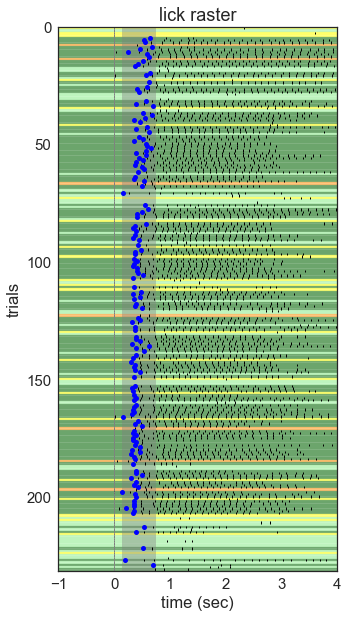

In [49]:
make_lick_raster(dataset.trials)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>The ResponseAnalysis class organizes cell responses by behavior trials and stimulus flashes </h2>
<p>The `ResponseAnalysis` class takes a `VisualBehaviorDataset` object and extracts cell responses for the stimulus flashes in `stimulus_table` and for the trials in `trials`. 
<p>This does the work of temporal alignment for you, and translates between `timestamps_stimulus` and `timestamps_ophys` to get the times in the dF/F trace that correspond to stimulus presentations in `stimulus_table` and behavioral trial change times in `trials`.
<p>
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 5.1:** Generate the ResponseAnalysis object by passing in your dataset. 

<p>Generate the `ResponseAnalysis` object by passing in your `dataset`. Assign the object to a variable called `analysis`.

<p> What is available to you in the `ResponseAnalysis` class? Use help to check the documentation, or look directly at the code to see what operations are performed. 
</div>

In [50]:
from visual_behavior.ophys.response_analysis.response_analysis import ResponseAnalysis 

In [51]:
analysis = ResponseAnalysis(dataset)

loading trial response dataframe
loading flash response dataframe


In [52]:
help(ResponseAnalysis)

Help on class ResponseAnalysis in module visual_behavior.ophys.response_analysis.response_analysis:

class ResponseAnalysis(__builtin__.object)
 |  Contains methods for organizing responses by trial or by  visual stimulus flashes in a DataFrame.
 |  
 |  For trial responses, a segment of the dF/F trace for each cell is extracted for each trial in the trials records in a +/-4 seconds window (the 'trial_window') around the change time.
 |  The mean_response for each cell is taken in a 500ms window after the change time (the 'response_window').
 |  The trial_response_df also contains behavioral metadata from the trial records such as lick times, running speed, reward rate, and initial and change stimulus names.
 |  
 |  For stimulus flashes, the mean response is taken in a 500ms window after each stimulus presentation (the 'response_window') in the stimulus_table.
 |  The flash_response_df contains the mean response for every cell, for every stimulus flash.
 |  
 |  Parameters
 |  -------

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 5.2: Explore the flash response dataframe of the ResponseAnalysis object**

<p>What is in the `flash_response_df` attribute of the analysis object? What are the columns? What are the rows?  How is it different from the `stimulus_table` attribute of the dataset object?

<p>The`flash_response_df` contains the cell responses for individual stimulus presentations, aka flashes. It contains the `mean_response` of every cell in a 500ms window after every stimulus onset, for all stimulus presentations during the behavior session.  

<p>The `p_value` column is computed as a one-way ANOVA comparing the values of the dF/F trace in the 500ms before the stimulus onset with the 500ms after the stimulus onset. 
</div>

In [53]:
analysis.flash_response_df.head()

,cell,flash_number,start_time,image_name,mean_response,p_value
0,0,0,69.00560,im047,0.085476,0.000085
1,0,1,69.75609,im047,0.024164,0.004968
2,0,2,70.50666,im047,0.018004,0.690715
3,0,3,71.25722,im047,0.017520,0.612907
4,0,4,72.00789,im047,0.203174,0.000124


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 5.3: Explore the trial response dataframe of the ResponseAnalysis object**

<p>1) Get the `trial_response_df` attribute of the analysis object. What are the columns? What are the rows? What is different than the `trials` records in the `dataset` object? What is different from the `flash_response_df`?

<p>The `trace` column contains a portion of each cell's dF/F trace for +/-4 seconds around the `change_time` for each trial. There are also `timestamps` for the same window of time. 

<p> For each trial, the `mean_response` of each cell is computed for a 500ms window after the `change_time`.

<p>The `p_value` is computed as a one-way ANOVA comparing the values of the dF/F trace in the 500ms before the `change_time` (the baseline window) with the 500ms after the `change_time` (the response window). 

<p>2) Assign `trial_response_df` to a variable named `tdf` for convenient use in later exercises.
</div>

In [54]:
analysis.trial_response_df.head(3)

,trial,cell,cell_specimen_id,trace,timestamps,mean_response,baseline_response,p_value,sd_over_baseline,running_speed_trace,...,behavioral_response_latency,rewarded,reward_times,reward_volume,reward_rate,start_time,end_time,trial_length,mouse_id,start_date_time
0,0,0,715928862,"[0.04136346595956865, -0.07527280432398697, -0...","[143.81806, 143.85035, 143.88264, 143.91493, 1...",0.011473,-0.009610,0.233731,0.250180,"[-0.06373431405115168, -0.06373431405115168, -...",...,2.33524,False,[],0.0,2.694428,144.80055,150.80546,6.005129,M384942,2018-06-28 15:57:29.511000-07:00
1,0,1,715928872,"[0.0432290347880467, 0.010222798373166286, 0.0...","[143.81806, 143.85035, 143.88264, 143.91493, 1...",0.011278,0.023997,0.238671,0.343256,"[-0.06373431405115168, -0.06373431405115168, -...",...,2.33524,False,[],0.0,2.694428,144.80055,150.80546,6.005129,M384942,2018-06-28 15:57:29.511000-07:00
2,0,2,715928874,"[0.29348558636801314, 0.18661819139900346, 0.1...","[143.81806, 143.85035, 143.88264, 143.91493, 1...",0.035940,0.055942,0.334127,0.552846,"[-0.06373431405115168, -0.06373431405115168, -...",...,2.33524,False,[],0.0,2.694428,144.80055,150.80546,6.005129,M384942,2018-06-28 15:57:29.511000-07:00


In [55]:
analysis.trial_response_df.keys()

Index([u'trial', u'cell', u'cell_specimen_id', u'trace', u'timestamps',
       u'mean_response', u'baseline_response', u'p_value', u'sd_over_baseline',
       u'running_speed_trace', u'running_speed_timestamps',
       u'mean_running_speed', u'change_time', u'initial_image_name',
       u'change_image_name', u'trial_type', u'trial_type_color',
       u'behavioral_response', u'behavioral_response_type', u'response_window',
       u'lick_times', u'behavioral_response_latency', u'rewarded',
       u'reward_times', u'reward_volume', u'reward_rate', u'start_time',
       u'end_time', u'trial_length', u'mouse_id', u'start_date_time'],
      dtype='object')

In [56]:
tdf = analysis.trial_response_df

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 5.4: Find the largest single trial response in the trial response dataframe**

<p>Each row of `trial_response_df` corresponds to a single trial for a single cell from the experiment. 

<p>1) Find the row of `tdf` that has the largest value of the `mean_response` column. Assign the trial number to a variable called `trial`.

<p>2) What cell had the largest response? Assign the cell index to the variable `cell`. You will use this cell throughout the rest of the notebook.

<p>3) What image evoked the largest response? Assign the image name to a variable called `change_image_name`

<p>4) Was it a 'go' or 'catch' trial? Assign the trial type to a variable called `trial_type`
</div>

In [57]:
largest_response = tdf[tdf.mean_response==tdf.mean_response.max()]
largest_response

,trial,cell,cell_specimen_id,trace,timestamps,mean_response,baseline_response,p_value,sd_over_baseline,running_speed_trace,...,behavioral_response_latency,rewarded,reward_times,reward_volume,reward_rate,start_time,end_time,trial_length,mouse_id,start_date_time
43259,188,207,715929688,"[0.1223962331947029, 0.1952696950284661, 0.045...","[3099.10347, 3099.13577, 3099.16807, 3099.2003...",4.054346,0.125125,1.001597e-07,34.628112,"[43.19576192424964, 45.498004882734875, 47.396...",...,0.38358,True,[3103.50241],0.007,4.188713,3098.59841,3106.85519,8.256962,M384942,2018-06-28 15:57:29.511000-07:00


In [58]:
cell = largest_response.cell.values[0]
print('cell with largest response:',cell)

cell with largest response: 207


In [59]:
trial = largest_response.trial.values[0]
print('trial that evoked largest response for this cell:',trial)

trial that evoked largest response for this cell: 188


In [60]:
image_name = largest_response.change_image_name.values[0]
print('image_name:', image_name)
trial_type = largest_response.trial_type.values[0]
print('trial_type:',trial_type)

image_name: im013
trial_type: go


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 5.5: Plot the largest single trial response in the trial_response_df**

<p>1) Plot the dF/F trace for the `trial` identified in the exercise above.

<p>Bonus: Plot the x_axis as time relative to the trial change time, using the `timestamps` column and knowledge of the range of the `trial_window` (+/- 4 seconds around the change time, accessed as an attribute of the `analysis` object)

<p>Extra bonus: Use the function `plot_single_trial_trace` from `visual_behavior.ophys.plotting.summary_figures` 
</div>

Text(0,0.5,'dF/F')

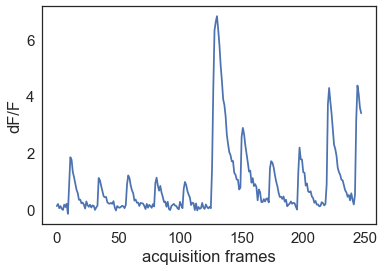

In [61]:
plt.plot(largest_response.trace.values[0])
plt.xlabel('acquisition frames')
plt.ylabel('dF/F')

Text(0,0.5,'dF/F')

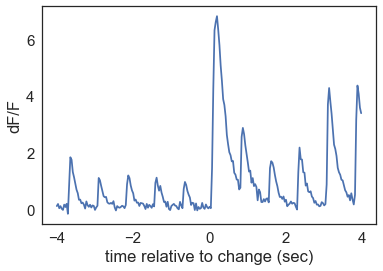

In [62]:
times = largest_response.timestamps.values[0]
times = times-times[0]
times = times-4
plt.plot(times,largest_response.trace.values[0])
plt.xlabel('time relative to change (sec)')
plt.ylabel('dF/F')

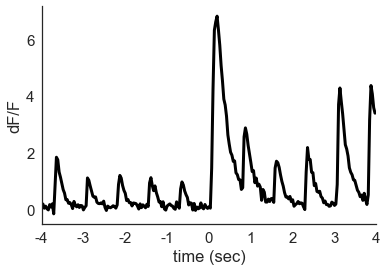

In [63]:
#Alternatively, use the plotting functions in visual_behavior.ophys.plotting.summary_figures
import visual_behavior.ophys.plotting.summary_figures as sf

trace = largest_response.trace.values[0]
frame_rate = analysis.ophys_frame_rate
sf.plot_single_trial_trace(trace, frame_rate, ylabel='dF/F', legend_label=None, color='k', interval_sec=1, xlims=[-4, 4], ax=None)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 5.6: Get the cell traces for all trials that meet the set of conditions that evoked the maximum single trial response**

<p>1) For your `cell`, get the dF/F traces in the `trace` column for all trials that meet the conditions that evoked the max response (combination of `trial_type` and `image_name` identified above) and assign to a variable called `traces`

<p>Hint 1: Use `cell`, `image_name`, and `trial_type` to index into `trial_response_df`

<p>Hint 2: Make sure to extract the an array of the values of response, not as a series
</div>

In [64]:
traces = tdf[(tdf.cell==cell)&(tdf.trial_type==trial_type)&(tdf.change_image_name==image_name)].trace
traces

436      [0.38802572651839096, 0.1996519686483635, 0.27...
2039     [0.05780539485471237, -0.014477366914353753, 0...
3642     [0.06584621714641109, 0.03893167270761867, -0....
4558     [-0.03178666016213838, -0.021963068906879116, ...
5703     [-0.053119954305885946, 0.06355718008644033, -...
10283    [-0.02170432517889446, 0.030635267847922996, 0...
12115    [0.09323095670060962, -0.04872577116788817, 0....
14176    [-0.10464897111540687, 0.028510047480076114, 0...
16924    [-0.041522022945915144, 0.19334264884938077, 0...
19672    [0.13868395169286477, 0.204171920824265, 0.075...
22191    [-0.02097421719937735, -0.015789370870768565, ...
23336    [0.13401822012640638, 0.04363675251884073, -0....
27229    [-0.11896568732479135, 0.08942483877679906, -0...
27687    [-0.19975970585864963, -0.04146177581409155, -...
29519    [-0.15528566011577166, 0.07007857946695023, -0...
30435    [0.020903726536218685, -0.07134666331389296, -...
33870    [0.027498651657965875, 0.0359309848535819, 0.1.

In [65]:
traces = traces.values

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 5.8: Plot the cell's' trial averaged trace for a set of conditions**

<p>1) Take the mean of the array of traces from exercise 5.5 and plot it. 

<p>What are the x and y axes? 

<p>Note the dynamics of the cell's response. What could be causing the changes in response magnitude over time? 
</div>

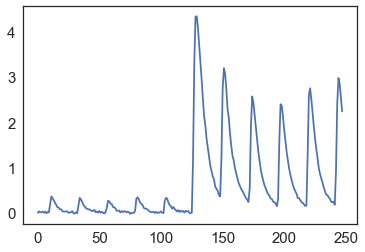

In [66]:
plt.plot(np.mean(traces))

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 5.8: Plot the cell's' trial averaged response for go and catch trials using visual_behavior library plotting functions**

<p>1) For your cell, get the dF/F traces for all trials for the same `image_name` as above, for 'go' trials. 

<p>2) Use the function `plot_mean_trace` in visual_behavior.ophys.plotting.summary_figures to plot the mean trace. 

<p>Check the required inputs for this function using help or by entering shift+tab while the function is selected. You will need to use the `ophys_frame_rate` attribute of the `analysis` class.

<p>3) Use the function `plot_flashes_on_trace` to display stimulus presentation times. When is the cell active relative to stimulus display times? 

<p>Provide a string for the `trial_type` input of `plot_flashes_on_trace`. What is the effect of adding this input on the resulting figure?

<p>4) Repeat for 'catch' trials. How is the response different than on 'go' trials? 
</div>

In [67]:
import visual_behavior.ophys.plotting.summary_figures as sf 

In [68]:
help(sf.plot_mean_trace)

Help on function plot_mean_trace in module visual_behavior.ophys.plotting.summary_figures:

plot_mean_trace(traces, frame_rate, ylabel='dF/F', legend_label=None, color='k', interval_sec=1, xlims=[-4, 4], ax=None)
    Function that accepts an array of single trial traces and plots the mean and SEM of the trace, with xticklabels in seconds
    
    :param traces: array of individual trial traces to average and plot. traces must be of equal length
    :param frame_rate: ophys frame rate if plotting a calcium trace, stimulus frame rate if plotting running speed
    :param y_label: 'dF/F' for calcium trace, 'running speed (cm/s)' for running speed trace
    :param legend_label: string describing trace for legend (ex: 'go', 'catch', image name or other condition identifier)
    :param color: color to plot the trace
    :param interval_sec: interval in seconds for x_axis labels
    :param xlims: range in seconds to plot. Must be <= the length of the traces
    :param ax: if None, create figur

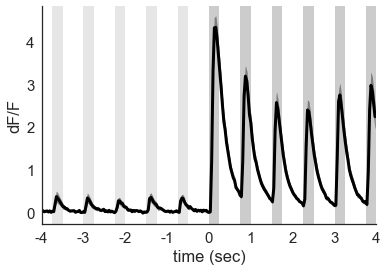

In [69]:
traces = tdf[(tdf.cell==cell)&(tdf.trial_type=='go')&(tdf.change_image_name==image_name)].trace
traces = np.asarray(traces)

fig,ax = plt.subplots()
sf.plot_mean_trace(traces, analysis.ophys_frame_rate, ylabel='dF/F', legend_label='go', color='k', interval_sec=1, xlims=[-4, 4], ax=ax)
sf.plot_flashes_on_trace(ax, analysis, trial_type='go', omitted=False, alpha=0.4)

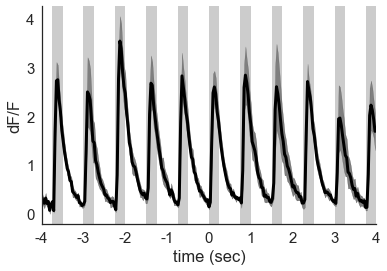

In [70]:
traces = tdf[(tdf.cell==cell)&(tdf.trial_type=='catch')&(tdf.change_image_name==image_name)].trace
traces = np.asarray(traces)

fig,ax = plt.subplots()
sf.plot_mean_trace(traces, analysis.ophys_frame_rate, ylabel='dF/F', legend_label=None, color='k', interval_sec=1, xlims=[-4, 4], ax=ax)
sf.plot_flashes_on_trace(ax, analysis, trial_type=None, omitted=False, alpha=0.4)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 5.9: Plot an image tuning curve for responses to the first flash after a change on 'go' trials**

<p>1) Filter `trial_response_df` to select only 'go' trials and assign to a variable called `df`.

<p>The `mean_response` column of the `trial_response_df` is the mean of the dF/F trace in a 500ms window after the change time for that trial.

<p>2) Loop through each `change_image_name` in `df.change_image_name.unique()` and get the values of the `mean_response` column for your `cell`.

<p>3) Take the average and SEM of the `mean_response` values for each `change_image_name` and plot a tuning curve. 

<p>Hint: use `from scipy.stats import sem` to get a function to compute the standard error. 

<p>How does the tuning curve compare with the one generated in exercise 5.9 using all stimulus presentations? Why would it be different?

<p>4) Save the averaged response to each image as an array called 'image_responses'.
</div>

In [71]:
from scipy.stats import sem

In [72]:
df = analysis.trial_response_df[(analysis.trial_response_df.trial_type=='go')]

In [73]:
images = np.sort(df.change_image_name.unique())
image_responses = []
sem_responses = []
for i,change_image_name in enumerate(images): 
    responses = df[(df.change_image_name==change_image_name)&(df.cell==cell)].mean_response.values
    mean_response = np.mean(responses)
    sem_response = sem(responses)
    image_responses.append(mean_response)
    sem_responses.append(sem_response)
image_responses = np.asarray(image_responses)
sem_responses = np.asarray(sem_responses)

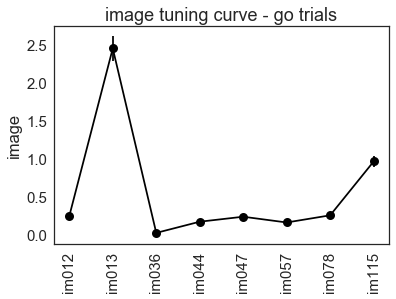

In [74]:
x_vals = np.arange(0,len(images),1)
plt.plot(x_vals,image_responses,'o',color='k')
plt.errorbar(x_vals,image_responses,yerr=sem_responses,color='k')
plt.xticks(np.arange(0,len(images),1),images,rotation=90);
plt.ylabel('mean dF/F');
plt.ylabel('image');
plt.title('image tuning curve - go trials');

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> Computing cell response metrics - lifetime sparseness </h2>
<p>'lifetime sparseness' is a metric for how selective and sparse a cell's activity is across conditions. A high value of this metric indicates high selectivity - a differential response to one or a few stimulus conditions over others. A low value of this metric indicates a similar response across all conditions. 

<p>We will compute this metric for single cells and take the mean across the population. Before taking the mean, we will filter out cells that do not have a signficant image response.
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Task 6.1: Compute lifetime sparseness using the mean image response on 'go' trials for your cell**
<p>Provide the array of `image_responses` created in Exercize 5.9 to the function below to compute the lifetime sparseness metric for your cell. 

<p>How selective is this cell? 
</div>

In [75]:
def compute_lifetime_sparseness(image_responses):
    # image responses should be an array of the trial averaged responses to each image
    # sparseness = 1-(sum of trial averaged responses to images / N)squared / (sum of (squared mean responses / n)) / (1-(1/N))
    # N = number of images
    # after Vinje & Gallant, 2000; Froudarakis et al., 2014
    N = float(len(image_responses))
    ls = ((1-(1/N) * ((np.power(image_responses.sum(axis=0),2)) / (np.power(image_responses,2).sum(axis=0)))) / (1-(1/N)))
    return ls

In [76]:
ls = compute_lifetime_sparseness(image_responses)
print(ls)

0.7362858140524864


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 6.2: Identify cells with a significant image response**
<p>The `p_value` column of the `trial_response_df` is computed as a one-way ANOVA comparing the values of the dF/F trace in the 500ms before the change time with the 500ms after the change time. This window is specified in the `response_window_duration` attribute of the `analysis` object. 

<p>Let's define responsive cells as having at least 10% of trials with a p_value < 0.005

<p>1) Loop through all cells, evaluate the fraction of trials with p_value < 0.005 and make a list of the indicies of responsive cells. Assign the list to a variable called `responsive_cells`.

<p>What fraction of cells in this experiment were responsive following a stimulus change? 

<p>***Add your value for fraction responsive cells to the plot on the board in the appropriate column based on your experiment's metadata***
</div>

In [77]:
responsive_cells = []
for cell in df.cell.unique():
    cell_data = df[(df.cell==cell)]
    total_trials = len(cell_data)
    responsive_trials = len(cell_data[cell_data.p_value<0.005])
    fraction_responsive_trials = responsive_trials/float(total_trials)
    if fraction_responsive_trials > 0.1: 
        responsive_cells.append(cell)

In [78]:
print('fraction responsive cells = ',len(responsive_cells)/float(len(analysis.trial_response_df.cell.unique())))

fraction responsive cells =  0.56768558952


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Exercise 6.3: Get the mean lifetime sparseness across  responsive cells** 

<p>1) Loop through each cell in `responsive_cells`, compute lifetime sparseness as you did above, and add the value to a list. 

<p>2) Convert the list to an array and take the mean.

<p>***Add your mean value to the plot on the board in the appropriate column based on your experiment's metadata***
</div>

In [79]:
images = np.sort(df.change_image_name.unique())
lifetime_sparseness_values = []
for cell in responsive_cells: 
    image_responses = []
    for i,change_image_name in enumerate(images): 
        responses = df[(df.cell==cell)&(df.change_image_name==change_image_name)].mean_response.values
        mean_response = np.mean(responses)
        std_err = sem(responses)
        image_responses.append(mean_response)
    ls = compute_lifetime_sparseness(np.asarray(image_responses))
    lifetime_sparseness_values.append(ls)
lifetime_sparseness_values = np.asarray(lifetime_sparseness_values)
mean_lifetime_sparseness = np.mean(lifetime_sparseness_values)

In [80]:
print('mean lifetime sparseness for go trials:',mean_lifetime_sparseness)

mean lifetime sparseness for go trials: 0.34487514007275616


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>**Bonus exercise 6.4: Compute lifetime sparseness for catch trials** 
    
<p>Repeat the exercise above using 'trial_response_df', filtered to include only 'catch' trials where no change in stimulus identity occured.

<p>How does the result compare to selectivity on 'go' trials only? Why would it be different? 
</div>

In [81]:
df = analysis.trial_response_df[(analysis.trial_response_df.trial_type=='catch')]

responsive_cells = []
for cell in df.cell.unique():
    cell_data = df[(df.cell==cell)]
    total_trials = len(cell_data)
    responsive_trials = len(cell_data[cell_data.p_value<0.005])
    fraction_responsive_trials = responsive_trials/float(total_trials)
    if fraction_responsive_trials > 0.1: 
        responsive_cells.append(cell)

images = np.sort(df.change_image_name.unique())
lifetime_sparseness_values = []
for cell in responsive_cells: 
    image_responses = []
    for i,change_image_name in enumerate(images): 
        responses = df[(df.cell==cell)&(df.change_image_name==change_image_name)].mean_response.values
        mean_response = np.mean(responses)
        std_err = sem(responses)
        image_responses.append(mean_response)
    ls = compute_lifetime_sparseness(np.asarray(image_responses))
    lifetime_sparseness_values.append(ls)
lifetime_sparseness_values = np.asarray(lifetime_sparseness_values)
mean_lifetime_sparseness = np.mean(lifetime_sparseness_values)

In [82]:
print('mean lifetime sparseness for catch trials:',mean_lifetime_sparseness)

mean lifetime sparseness for catch trials: 0.597375914416724


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> Project ideas </h2>
<p>Below is a list of suggested project ideas for working with the Visual Behavior dataset

</div>

* How do single cell or population response metrics vary between cre lines, areas or stimulus types? (ex: time-to-peak, reliability, fano factor, noise correlations, signal correlations, representational similarity, etc.)
* Are there distinct or continuous behavioral or neural states within a single behavioral session? (ex: task engagement, expectation, vigilance)
* How do response metrics vary across different states?
* Can different cell response profiles be classified using supervised or unsupervised clustering methods? 
* Do motor signals such as running and licking modulate neural respones in different cre lines or areas?
* Does reward expectation and trial history influence neural or behavioral responses? (ex: time since last reward, outcome of previous trial(s))
* Is there evidence of within session learning for untrained image sets? (behavior_session_B, C, D)
* How do cells respond when a stimulus flash is omitted? 
* Use dimensionality reduction or other methods to visualize the activity of many neurons at once. 